# Notebook to create simple statistics on a CONLL corpus (IOB)

Version : python 3.7

Last updated : 17/09/2021

Author : Lucas Terriel

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from nltk.tree import Tree
from nltk.chunk import conlltags2tree

### 1. Load the CONLL file (IOB format)

*N.B : CONLL files were gathered into a single file using the command `$ cat *.connl >> all.conll`* 

In [2]:
# Indiquer le chemin vers le fichier
file_path = "./datatest/sample/test/all.conll"
filename = os.path.basename(file_path)
with open(file_path, "r", encoding="utf-8") as f:
    conll = f.read()

### 2. Retrieving the number of sentences, annotated sentences and creation of lists of tokens, annotated tokens and tags

In [3]:
sentences = 1
sentences_annotated = 1
tokens = []
tags = []
tokens_tagged = []
# Intermediate list to test if the sentence contains annotated mentions.
inter_sentences_annotated = []

for row in conll.splitlines():
    pair = row.split(" ")
    # If the length of the list is equal to 1, this means
    # that we move on to a new sentence.
    if len(pair) == 1:
        sentences += 1
        if len(inter_sentences_annotated) > 0:
            sentences_annotated += 1
            inter_sentences_annotated = []
        else:
            inter_sentences_annotated = []
    else:
        mention = pair[0]
        ner_tag = pair[1]
        tokens.append(mention)
        tags.append(ner_tag)
        if ner_tag != "O":
            inter_sentences_annotated.append(ner_tag)
            mention_tagged = mention
            tokens_tagged.append(mention_tagged)

### 3. Creation of a dataframe to count the total of labels prefixed with the IOB scheme

In [4]:
iob_df = pd.DataFrame(tags, columns=['Label'])
iob_df = iob_df.value_counts().to_frame('Total').reset_index()
# Remove "O" Tags.
iob_df = iob_df.loc[iob_df.Label.str.len()>2]
# iob_df

### 4. Verification of token lists and IOB tags

In [5]:
print(tokens[0:20])
print(tags[0:20])

# sanity check
assert len(tokens) == len(tags), 'length between tokens and tags is not the same.'

['JJ', '/', '/', '226', '/', 'A', '465', 'Vincennes', '.', 'Confirmation', 'des', 'privilèges', 'de', 'la', "villed'Aire", '1', ',', 'au', 'bailliage', "d'Amiens"]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANISATION', 'I-ORGANISATION']


### 4. Build NLTK tree to reconstruct the chunked entities in a single NER class

Tutorial : [Jeril Kuriakose, *BIO / IOB Tagged Text to Original Text*, medium, 2019](https://medium.com/analytics-vidhya/bio-tagged-text-to-original-text-99b05da6664)

In [6]:
# We assume to set POS_TAGS with "_" value. By default, NLTK's CONLL Reader accepts three values ​​(Mention, POS, NER Tags)
conlltags = [(token, "_", tg) for token, tg in zip(tokens, tags)]
ne_tree = conlltags2tree(conlltags)

In [7]:
original_text = []
for subtree in ne_tree:
    # Pass the "O" tags
    if type(subtree) == Tree:
        original_label = subtree.label()
        original_string = " ".join([token for token, _ in subtree.leaves()])
        original_text.append((original_string, original_label))
        
print(original_text[0:10])

[('Vincennes', 'LOCATION'), ("bailliage d'Amiens", 'ORGANISATION'), ('Aire-sur-la-Lys', 'LOCATION'), ('Pas-de-Calais', 'LOCATION'), ('arr . de Saint-Omer', 'LOCATION'), ('Paris', 'LOCATION'), ('Jean Le Douch , dit Mesgret', 'PERSON'), ('Herly', 'LOCATION'), ("bailliage d'Amiens", 'ORGANISATION'), ("Martinot , d'Ambricourt", 'PERSON')]


### 5. Creation of a dataframe to count the total of nonchunked labels

In [8]:
df_entities = pd.DataFrame(original_text, columns=['Mention', 'Label'])
df_sum_labels = df_entities['Label'].value_counts().to_frame('Total').reset_index()
df_sum_labels.rename(columns = {'index':'Label'}, inplace = True)
total_entities = df_sum_labels['Total'].sum()

# sanity check
assert total_entities == len(original_text)

### 6. Visualization of all the results

General statistics on the corpus : all.conll 
|- Total number of sentences : 106513
|- Total number of tokens : 1393798
|- Total number of annotated sentences : 850
|- Total number of annotated chunked tokens (IOB) : 5368
|- total number of entities (IOB merge) : 2256


,Label,Total
1,B-LOCATION,903
2,I-ORGANISATION,749
3,I-PERSON,705
4,I-TITLE,678
5,I-LOCATION,605
6,B-PERSON,490
7,B-TITLE,355
8,B-ORGANISATION,308
9,I-INSTALLATION,225
10,I-EVENT,186


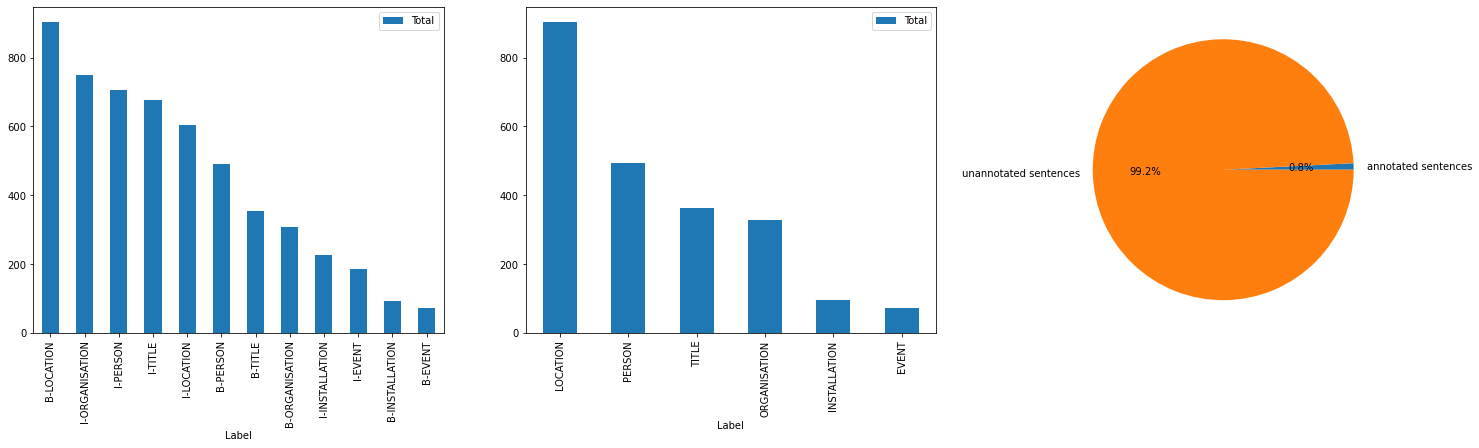

In [9]:
from IPython.display import display_html 

print(f"General statistics on the corpus : {filename} ")
print(f"|- Total number of sentences : {sentences}")
print(f"|- Total number of tokens : {len(tokens)}")
print(f"|- Total number of annotated sentences : {sentences_annotated}")
print(f"|- Total number of annotated chunked tokens (IOB) : {len(tokens_tagged)}")
print(f"|- total number of entities (IOB merge) : {len(original_text)}")

# Creation of containers for displaying dataframes side-by-side.
df1_styler = iob_df.style.set_table_attributes("style='display:inline'").set_caption("Total number of chunked labels")
df2_styler = df_sum_labels.style.set_table_attributes("style='display:inline'").set_caption("Total number of entities per NER class")

# A single figure to plot the graphs next to each other
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,6))
# Bar charts for labels
df1_plot = iob_df.plot(kind='bar', x='Label', y='Total', ax=ax1)
df2_plot = df_sum_labels.plot(kind='bar', x='Label', y='Total', ax=ax2)

# Pie plot for the sentences
percentage_annotated_sentences = sentences_annotated / sentences * 100
percentage_non_annotated_sentences = (sentences - sentences_annotated) / sentences * 100
sentences_values = [percentage_annotated_sentences, percentage_non_annotated_sentences]
sentences_labels = ['annotated sentences', 'unannotated sentences']
pie3 = ax3.pie(sentences_values,labels=sentences_labels, autopct='%1.1f%%')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
plt.show()